## Meghana Ravikumar
 
## Neural Net Digit Classification

In [59]:
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import scipy.io
import math
import random
import itertools
import matplotlib.pylab as plt
%matplotlib inline

## Importing Data

### The given digit data is preprocessed by normalizing the pixel values. This was done by dividing all of the given pixel values by the maximum value of the pixels. The data was also shuffled and split into training and validation sets. This was done in the hopes that the neural net wouldn't over-fit for certain digits due to repeatedly seeing the same digit back to back. 

In [3]:
class ProcessData(object):
    
    def __init__(self):
        self.data_train = None
        self.data_labels = None
        self.data_test = None
        
    def importData(self, path_train = "./dataset/train.mat", path_test = "./dataset/test.mat"):
       
        data_train = scipy.io.loadmat(path_train)['train_images']
        data_trainF = np.zeros((60000,784))
        for dt2 in range(0,60000):
            data_trainF[dt2] = data_train[:,:,dt2].reshape(784)
        max_pixel = data_train.max()
        self.data_train = np.true_divide(data_trainF,max_pixel)
        
        self.data_labels = scipy.io.loadmat(path_train)['train_labels']
        
        data_test = scipy.io.loadmat(path_test)['test_images']
        digit_testing_flattened= np.zeros((10000,784))
        for dtInd in range(0,10000):
            digit_testing_flattened[dtInd] = data_test[dtInd,:,:].reshape(784)
        self.data_test = np.true_divide(digit_testing_flattened,max_pixel)
        
        return self.splitting_data()
    
    def splitting_data(self):
        dataset_labels = self.data_labels
        dataset_train = self.data_train
        
        total_dataset = np.hstack((dataset_train,dataset_labels))
        total_permuted = np.random.permutation(total_dataset)
        
        training_set, validation_set = np.split(total_permuted,[50000],0)
        
        data_train, train_labels = np.split(training_set, [training_set.shape[1]-1], 1)
        data_validate, validate_labels = np.split(validation_set, [validation_set.shape[1]-1],1)
        
        data_train = np.hstack((data_train,np.ones((data_train.shape[0],1))))
        data_validate = np.hstack((data_validate,np.ones((data_validate.shape[0],1))))
        self.data_test = np.hstack((self.data_test,np.ones((self.data_test.shape[0],1))))
        
        return data_train, train_labels, data_validate, validate_labels, self.data_test

In [4]:
digit_data = ProcessData()
data_train, train_labels, data_validate, validate_labels, data_test = digit_data.importData()

## Building and Training the Net

### The neural net class below builds, trains, and tests a neural net. The parameters can be specified to be stochastic or batch gradient descent along with being able to change input size. The learning rate is characterized by the parameter "epsilon". In the case of batch gradient descent, the net uses reLU as the activation function for the hidden units and softmax for the output units. In the case of stochastic gradient descent, the net uses tanh() as the activation function for hidden units and a clamped sigmoid function for its output units. By manually attempting many learning rates, it was shown to be most useful to use epsilon = 0.01 for stochastic gradient descent using the MSE or cross-entropy cost functions. The weight gradients required to perform gradient descent are attached to this document as another pdf. The derivatives that were calculated are: dJ/dW and dJ/dV for both the MSE and Cross-Entropy cost functions.

In [72]:
class neuralNet(object):
    '''Class will be used to build and train a neural net'''
    
    def __init__(self, data, labels, inputSize, hiddenSize, outputSize, costFn,req_acc,epsilon, SGD):
        self.data = data
        self.labels = labels
        self.hiddenSize = hiddenSize
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.costFn = costFn
        self.req_acc = req_acc
        self.epsilon = epsilon
        self.V= None
        self.W = None
        self.x1 = None
        self.hidden = None
        self.output = None
        self.yHat = None
        self.SGD = SGD
        
    def weights(self):
        self.V = np.random.normal(0, 0.01, (self.inputSize+1, self.hiddenSize))
        self.W = np.random.normal(0, 0.01, (self.hiddenSize+1, self.outputSize))
        
    def sigmoid(self,dataset):
        grt0 = np.where(dataset[0]>=0)[0]
        les0 = np.where(dataset[0]<0)[0]
        dataset[0][grt0] = float(1)/(1+np.exp(-dataset[0][grt0]))
        dataset[0][les0] = (np.exp(dataset[0][les0]))/(1+np.exp(dataset[0][les0]))
        return dataset
        

    def tanh(self,dataset):
        return np.tanh(dataset)
    
    def derivSig(self):
        return (self.yHat)*(float(1)-self.yHat)
    
    def derivTanh(self,dataset):
        return 1-np.square(dataset)
    
    ####RELU implemented here -- change sigmoid with softmax
    def reLU(self,dataset):
        dataset = np.maximum(dataset,float(0))
        return dataset
    
    def dreLU(self,dataset):
        dataset[dataset<=0]=float(0)
        return dataset
        
    def softmax(self,dataset):
        scores = np.exp(dataset)
        summed = np.sum(scores,1)
        toRtn = scores/summed.reshape(summed.shape[0],1)
        return toRtn
       
    #########
    
    def nOut(self, label):
        encoded = np.zeros(10)
        encoded[int(label)] = float(1)
        return encoded
    
    def cost(self,Y):
        yHat = self.yHat
        if self.costFn == True:
            ## calculates cost for least squares
            c= np.sum(np.square(Y-yHat))*(0.5)
        else:
            ##calculates cost for cross entropy
            pt1 = np.sum(np.log(yHat)*Y)
            pt2 = np.sum(np.log(1-yHat)*(1-Y))
            c = -1*(pt1+pt2)
        return c
        
    
    def findLabel(self, dataset):
        '''Function used to go through each row of yHat and find maximum--> set to 1 and rest to 0'''
        max_prb = np.max(dataset)
        dataset[dataset<max_prb] = float(0)
        dataset[dataset == max_prb] = float(1)
        return dataset
    
    def findLabel2(self,dataset):
        return np.argmax(dataset)
    
    def labelToMatTrain(self,labels):
        labels2 = np.array([])
        for label in labels:
            if len(labels2)== 0:
                labels2 = self.nOut(label)
            else:
                labels2 = np.vstack((labels2, self.nOut(label)))
        self.nOutTrain = labels2
    
    def labelToMatTest(self,labels):
        labels2 = np.array([])
        for label in labels:
            if len(labels2)== 0:
                labels2 = self.nOut(label)
            else:
                labels2 = np.vstack((labels2, self.nOut(label)))
        self.nOutTest = labels2
    
    def forwardProp(self,X):
        self.x1 = np.dot(X, self.V)
        if self.SGD == True:
            self.hidden = np.hstack((self.tanh(self.x1), np.ones((self.x1.shape[0],1))))
            self.output = np.dot(self.hidden, self.W)
            self.yHat= self.sigmoid(self.output)
        else:
            self.hidden = np.hstack((self.reLU(self.x1), np.ones((self.x1.shape[0],1))))
            self.output = np.dot(self.hidden, self.W)
            self.yHat= self.softmax(self.output)
        
    def backwardProp(self,X,Y):
        if self.costFn == True: ## True will indicate least-squares
            pt1 = np.multiply((Y-self.yHat), (-1*self.derivSig()))
            derW = np.dot(self.hidden.T, pt1)
            pt2 = np.dot(pt1,np.delete(self.W, self.W.shape[0]-1,0).T)*self.derivTanh(
                np.delete(self.hidden,self.hidden.shape[1]-1,1))###take column off of hidden
            derV = np.dot(X.T, pt2)
        else: 
            ## cross-entropy cost function
            pt1 = self.yHat-Y
            derW = np.dot(self.hidden.T,pt1)
            pt2 = np.dot(pt1,np.delete(self.W, self.W.shape[0]-1,0).T)*self.derivTanh(
                np.delete(self.hidden,self.hidden.shape[1]-1,1))
            derV = np.dot(X.T,pt2)
            
        return (derW, derV)
    
    def backProp_reLU(self,X,Y):
        ##will only use cross-entropy function
        pt1 = self.yHat-Y
        derW = np.dot(self.hidden.T,pt1)
        pt2 = np.dot(pt1,np.delete(self.W, self.W.shape[0]-1,0).T)*self.dreLU(
                np.delete(self.hidden,self.hidden.shape[1]-1,1))
        derV = np.dot(X.T,pt2)
        return (derW, derV)
        
    
    def train(self,test_data,test_labels,max_it):
        '''Stochastic Gradient descent shall be implemented in this method. The data will be shuffled and 
        a sample shall be chosen at random. The weights shall be calculated and updated. This process will
        continue until a threshold has been met.'''
        allData = self.data
        self.weights() ##initialize the random weights
        self.labelToMatTrain(self.labels)
        self.labelToMatTest(test_labels)
        acc = 0
        n=0 #epoch
        epsilon = self.epsilon
        while acc < self.req_acc: ##max iterations = # epochs
            if self.SGD == True:
                shuffled = np.random.permutation(np.arange(allData.shape[0]))
            else:
                ## will shuffle and split the data here for batch gradient descent
                mergedData = np.hstack((allData, self.nOutTrain))
                permuted = np.random.permutation(mergedData)
                rowSplit = np.split(permuted,100)
                shuffled = []
                for rSplit in rowSplit:
                    curr = np.split(rSplit,[rSplit.shape[1]-self.nOutTrain.shape[1]],1)
                    shuffled.append(curr) ##appending 
            
            print "in epoch"
            cnt = 0
            costX=[]
            accX = []
            ids = []
            for rowInd in shuffled:
                cnt = cnt + 1
                if self.SGD == True:
                    dataPoint = allData[rowInd,:].reshape(1,allData.shape[1])
                    Y = self.labels[rowInd] ##scalar - need to make it into a vector 
                    Y = self.nOut(Y)
                    self.forwardProp(dataPoint)
                    derW, derV = self.backwardProp(dataPoint,Y)
                else:
                    #performing mini-batch gradient descent
                    dataPoint = rowInd[0]
                    Y = rowInd[1]
                    self.forwardProp(dataPoint)
                    derW, derV = self.backProp_reLU(dataPoint,Y)
                    
                self.W = self.W - epsilon*derW
                self.V = self.V - epsilon*derV
                if (cnt%1000 == 0 and self.SGD == True) or (cnt%10 == 0 and self.SGD == False):
                    ids.append(cnt)
                    currCost = self.cost(Y)
                    print "the current cost is:"
                    print currCost
                    costX.append(currCost)
                    acc,predictions = self.validate(test_data,test_labels)
                    accX.append(acc)
                    print "the current accuracy is:"
                    print acc
                    print predictions
                    if acc >= self.req_acc:
                        break     
            n = n + 1
            if n >= max_it:
                acc, predictions = self.validate(test_data,test_labels)
                print acc
                print predictions
                break
                    
        return self.W, self.V, ids, costX, accX

    
    def validate(self, test_data, test_labels):
        '''Method will be used to test accuracy of built neuron.'''
        self.forwardProp(test_data)
        derW, derV = self.backwardProp(test_data,self.nOutTest)
        yHat = self.yHat
        predictions = np.apply_along_axis(self.findLabel2,1,yHat) ##vector [0,9]
        acc = self.accuracy(predictions, test_labels)
        return acc,predictions
    
    def accuracy(self,predicted_values, trueLabels):
        count = 0
        for v in range(len(predicted_values)):
            if predicted_values[v] == trueLabels[v]:
                count = count +1 
        return float(count)/len(predicted_values)
    
    def test(self, test_data):
        self.forwardProp(test_data)
        derW, derV = self.backwardProp(test_data,self.nOutTest)
        yHat = self.yHat
        predictions = np.apply_along_axis(self.findLabel2,1,yHat) ##vector [0,9]
        return predictions
        



## Testing the Net

### The following neural net is trained using stochastic gradient descent with a cross-entropy cost function, a learning rate of 0.01, a desired accuracy of 0.99, and max epochs (an epoch is defined to be one iteration through all the data points in the digit matrix). to be 12. The number of epochs used is 12 and reaches an accuracy of 0.97 when validated on the validation data. The training stopped if it hit a maximum epoch number or a desired accuracy rate (here set to 0.99). The net took approximately an hour to train. The weights were generated randomly from a Gaussian distribution: N~(0,10^-2)

In [57]:
neuron = neuralNet(data= data_train,labels= train_labels, inputSize =784, hiddenSize = 200, 
                   outputSize = 10, costFn = False, req_acc = 0.99, epsilon = 0.01, SGD = True)
update = neuron.train(data_validate, validate_labels,12)
predictions = neuron.test(data_test)

in epoch
the current cost is:
1.27525781672
the current accuracy is:
0.6311
[1 0 0 ..., 7 6 3]
the current cost is:
1.06744202859
the current accuracy is:
0.7674
[1 0 0 ..., 7 6 5]
the current cost is:
0.276357129347
the current accuracy is:
0.7897
[1 0 0 ..., 7 6 5]
the current cost is:
3.04384804105
the current accuracy is:
0.8131
[1 0 0 ..., 7 6 5]
the current cost is:
0.176699083404
the current accuracy is:
0.8282
[1 0 0 ..., 7 6 5]
the current cost is:
0.517050679411
the current accuracy is:
0.8283
[1 0 0 ..., 7 6 5]
the current cost is:
2.25278125993
the current accuracy is:
0.8591
[1 0 0 ..., 7 6 5]
the current cost is:
0.0933940783053
the current accuracy is:
0.8675
[1 0 0 ..., 7 6 5]
the current cost is:
1.03733857125
the current accuracy is:
0.8613
[1 0 0 ..., 7 6 5]
the current cost is:
1.77730147246
the current accuracy is:
0.855
[1 0 0 ..., 7 6 5]
the current cost is:
0.0533157330525
the current accuracy is:
0.8729
[1 0 0 ..., 7 6 5]
the current cost is:
0.178664714055
the

### The following graphs depict the cost vs. iteration number and accuracy vs. iteration for the cross-entropy trained neural net.

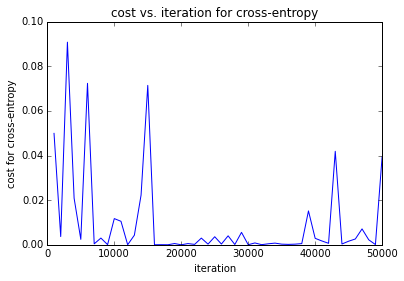

In [64]:
plt.plot(update[2],update[3])
plt.ylabel('cost for cross-entropy')
plt.xlabel('iteration')
plt.title('cost vs. iteration for cross-entropy')

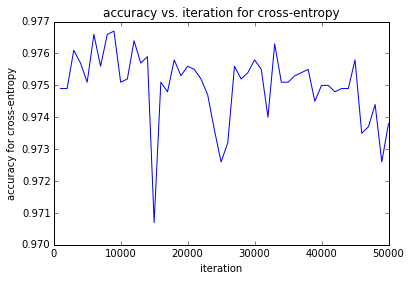

In [65]:
plt.plot(update[2],update[4])
plt.ylabel('accuracy for cross-entropy')
plt.xlabel('iteration')
plt.title('accuracy vs. iteration for cross-entropy')

### The following neural net is built using the MSE cost function, a learning rate of 0.01, 5 epochs (an epoch is defined as iterating through all the samples in the digit data matrix) at max, desired accuracy of 0.99, and stochastic gradient descent. If the maximum number of epochs is reached or if the desired accuracy of 0.99 is reached, the net stops training.  The training took approximately 15 mins. The weights were generated randomly from a Gaussian distribution: N~(0,10^-2). The final validation accuracy is: 0.94

In [73]:
neuron3 = neuralNet(data= data_train,labels= train_labels, inputSize =784, hiddenSize = 200, 
                   outputSize = 10, costFn = True, req_acc = 0.99, epsilon = 0.01, SGD = True)
update3 = neuron3.train(data_validate, validate_labels,5)
predictions3 = neuron3.test(data_test)

in epoch
the current cost is:
0.449133936283
the current accuracy is:
0.1445
[1 0 1 ..., 1 1 1]
the current cost is:
0.383519137713
the current accuracy is:
0.2282
[1 0 0 ..., 7 1 1]
the current cost is:
0.473747520411
the current accuracy is:
0.2243
[1 0 0 ..., 0 0 0]
the current cost is:
0.429484962577
the current accuracy is:
0.3312
[1 0 0 ..., 7 6 0]
the current cost is:
0.07679765941
the current accuracy is:
0.447
[1 0 0 ..., 7 4 0]
the current cost is:
0.457941650409
the current accuracy is:
0.5148
[1 0 0 ..., 7 6 6]
the current cost is:
0.442378028647
the current accuracy is:
0.5588
[1 0 0 ..., 7 6 3]
the current cost is:
0.580078024161
the current accuracy is:
0.6116
[1 0 0 ..., 7 6 3]
the current cost is:
0.134951374406
the current accuracy is:
0.6331
[1 0 0 ..., 7 6 3]
the current cost is:
0.435826675079
the current accuracy is:
0.7182
[1 0 0 ..., 7 6 5]
the current cost is:
0.0536977308432
the current accuracy is:
0.7085
[1 0 0 ..., 7 6 3]
the current cost is:
0.028685488950

### The following graphs depict the cost vs. iteration number and accuracy vs. iteration for the MSE trained neural net.

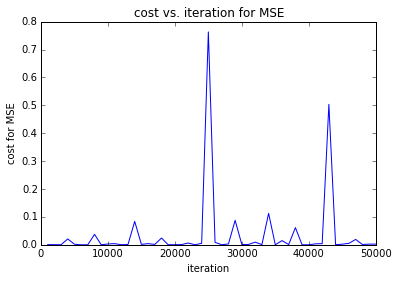

In [75]:
plt.plot(update3[2],update3[3])
plt.ylabel('cost for MSE')
plt.xlabel('iteration')
plt.title('cost vs. iteration for MSE')

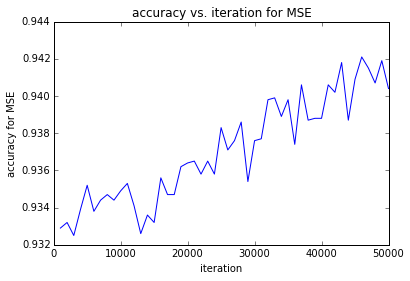

In [76]:
plt.plot(update3[2],update3[4])
plt.ylabel('accuracy for MSE')
plt.xlabel('iteration')
plt.title('accuracy vs. iteration for MSE')

### As seen above, using cross-entropy or MSE for training results in varying costs per iteration. On average, the MSE has a lower cost per iteration. Furthermore, the accuracy using MSE seems to be on a steady incline, where if there were more epochs allowed could lead to a higher accuracy or some form of plateau. The accuracy using cross-entropy seems to on average retain a certain accuracy level. The accuracy level using the cross-entropy cost function seems to be higher than that using MSE. The high accuracy found using the cross-entropy cost fuction can be attained at a smaller number of iterations than that that for MSE. 
### Many epsilon values were manually tried to attain better accuracy and minimize cost, resulting in 0.01 being an optimal number for neural nets using MSE or cross-entropy. The epsilon value was also changed to decrease with the iteration (so the first iteration would have a higher learning rate vs the 10th iteration). This lead to nets using both MSE and cross-entropy to plateau at lower accuracies than the ones attained above. The accuracy of both methods can be improved using reLU and softmax. Although partial implementations are given above, dimension issues and time constraint have prevented them from being fully implemented. Another way to improve accuracy would be to simulate rotations and shifts as synthetic data and include those in the training of the neural net.

## Kaggle

### The highest kaggle score attained for a neural net using MSE: 0.957
### The highest kaggle score attained for a neural net using cross-entropy: 0.9734


In [78]:
def writeToCSV(fileName, predictions):
    import csv
    with open(fileName, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Id','Category'])
        shl = 1
        for pred_l in predictions:
            writer.writerow([shl,int(pred_l)])
            shl = shl + 1

In [79]:
writeToCSV('neural_pred_cross.csv', predictions)

In [80]:
writeToCSV('neural_pred_MSE.csv', predictions3)